In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jlaks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jlaks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Read in data

In [4]:
df = pd.read_csv('Reviews.csv')

In [5]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [6]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [7]:
df.shape

(568454, 10)

In [8]:
df = df.head(50000)
print(df.shape)

(50000, 10)


## EDA

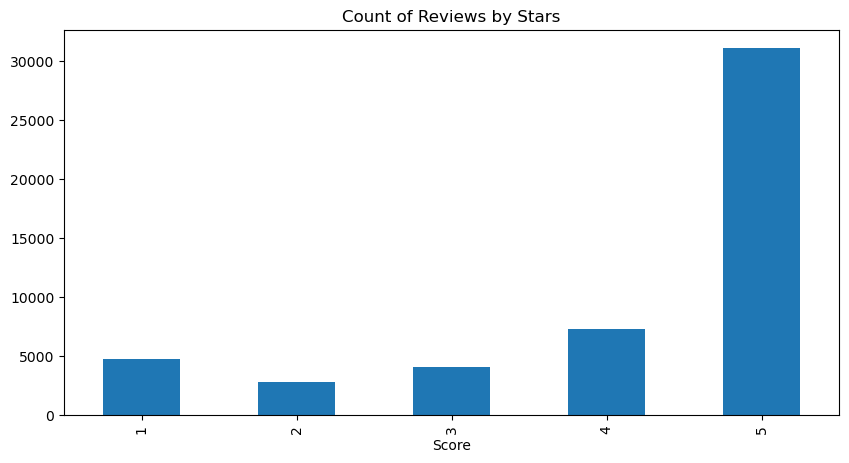

In [10]:
ax = df['Score'].value_counts().sort_index() \
        .plot(kind = 'bar', 
              title = 'Count of Reviews by Stars', 
              figsize = (10, 5))

ax.set_label('Review Stars')
plt.show()

## Get Sentiment

In [12]:
def convert_sentiment(score):
    if score in [1, 2]:
        return 0  # Negative
    elif score in [4, 5]:
        return 1  # Positive
    else:
        return None  # Drop neutral (score == 3)

df['Sentiment'] = df['Score'].apply(convert_sentiment)
df = df.dropna(subset=['Sentiment'])  # Drop neutral rows
df['Sentiment'] = df['Sentiment'].astype(int)

## Basic NLTK : Preprocessing Enhancement

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['cleaned_review'] = df['Text'].apply(preprocess_text)


## TF-IDF Vectorization

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['cleaned_review']).toarray()
y = df['Sentiment']

## Apply SMOTE to balance the data

In [18]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

  File "D:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


## Logistic Regression Model

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

## Evaluation

Accuracy: 0.8938703800104112

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      7684
           1       0.90      0.88      0.89      7684

    accuracy                           0.89     15368
   macro avg       0.89      0.89      0.89     15368
weighted avg       0.89      0.89      0.89     15368



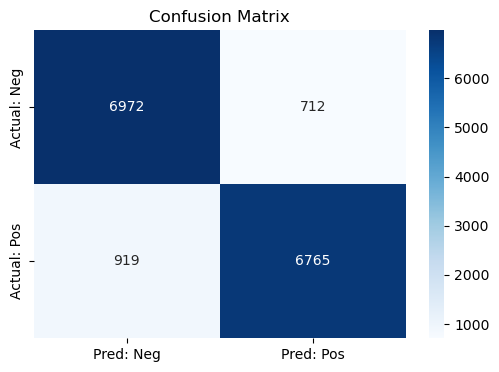

In [48]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Neg', 'Pred: Pos'],
            yticklabels=['Actual: Neg', 'Actual: Pos'])
plt.title('Confusion Matrix')
plt.show()



In [50]:
# 1. Predictions on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 2. Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(train_acc)
print(test_acc)

0.8990694345025053
0.8938703800104112
